Бежим по входному изображению сверткой 5x5 с шагом 5. Классифицируем каждый кусочек как сторону доски кроссэнтропией.

In [2]:
import os
os.chdir('/home/bfilippov/whiteboard')

import keras
import pandas as pd
import ast

import cv2
import tensorflow as tf
import numpy as np
from keras.layers import Input
from keras import backend as K
from keras.models import Model
from keras.applications import VGG16
from models.model_zoo import whiteboard_detector, whiteboard_loss
from models.image_generator import whiteboard_images


train = pd.read_csv('source/train.csv')
test = pd.read_csv('source/test.csv')
train['labels'] = train['labels'].map(ast.literal_eval)
test['labels'] = test['labels'].map(ast.literal_eval)

valid = train.sample(frac=0.2, random_state=1313)
train = train.drop(valid.index)

smooth = 1e-12


def stretch_n(bands, lower_percent=0, higher_percent=100):
    out = np.zeros_like(bands, dtype=np.float32)
    n = bands.shape[2]
    for i in range(n - 1):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    out[:, :, n - 1] = bands[:, :, n - 1]
    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)


def cv_feature_maps(image):
    image = stretch_n(image)
    alpha = image[:, :, 3].copy() # special mask used to ignore image-augmentation artifacts
    gray = (cv2.cvtColor(image[:, :, :3].astype(np.float32), cv2.COLOR_RGB2GRAY) * 255).astype(np.uint8)
    edges = cv2.Canny(gray, 100, 250)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 25, minLineLength=50, maxLineGap=50)

    corners = cv2.cornerHarris(edges,2,3,0.01)
    corners = cv2.dilate(corners,None)

    hough = np.zeros(gray.shape, np.float)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(hough, (x1, y1), (x2, y2), 1, 2)

    def norm(img):
        return cv2.normalize(img, img, 0, 1, norm_type=cv2.NORM_MINMAX,
                             dtype=cv2.CV_32F)
    del image
    feature_maps = [norm(img) for img in [gray, edges, corners, hough, alpha]]
    return np.stack(feature_maps, axis=2)


def patch_generator(dirname, generator):
    class Next:
        def __next__(self):
            batch_x, batch_y = next(generator)
            self.batch_y = batch_y
            return batch_x
    return Next()

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config=config)
K.set_session(sess)


from keras.models import Model, Sequential
from keras.layers import (
    Dense, Convolution2D, MaxPooling2D, Activation,
    Input, BatchNormalization, Dropout, merge, UpSampling2D
)
from keras.layers.advanced_activations import LeakyReLU
from models.model_zoo import residual_block


def scale(N, i, scaler=2):
    return int(N * (scaler**i))


def down_res(name, in_layer, dropout_pb, nb_filters, patch_size, ):
    downsampled = downsample(in_layer, 'pool_' + name)
    normalized = BatchNormalization(name='pool_norm_' + name)(downsampled)
    dropped = Dropout(dropout_pb)(normalized)
    deepened = Convolution2D(nb_filters, patch_size, patch_size, name='deep_' + name,
                             border_mode='same', activation=LeakyReLU())(dropped)
    return residual_block(name, deepened, dropout_pb, nb_filters, patch_size)


def up_res(name, in_layer, par_layer, dropout_pb, nb_filters, patch_size):
    normalized = BatchNormalization(name='up_norm_' + name)(in_layer)
    dropped = Dropout(dropout_pb)(normalized)
    shallowed = Convolution2D(nb_filters, patch_size, patch_size, name='shallow_' + name,
                              border_mode='same', activation=LeakyReLU())(dropped)
    renormalized = BatchNormalization(name='shallow_norm_' + name)(shallowed)
    redropped = Dropout(dropout_pb)(renormalized)
    upsampled = upsample(redropped, par_layer, name)
    return residual_block(name, upsampled, dropout_pb, 2 * nb_filters, patch_size)


def downsample(in_layer, layer_name):
    return MaxPooling2D(pool_size=(2, 2), name=layer_name)(in_layer)

def upsample(in_layer, par_layer, layer_name):
    upsample_name = 'up_' + layer_name
    merge_name = 'concat_' + layer_name
    return merge([UpSampling2D(size=(2, 2), name=upsample_name)(in_layer), par_layer],
                 mode='concat', concat_axis=3, name=merge_name)

model_weights = 'models/weights/big_unet_resnet_detector_jaccard.hf5'
nb_cv_features=5
input_height = 160
input_width = 160
nb_filters = 16
patch_size = 3
dropout_pb = 0.5

img_size = (input_height, input_width)
img_dir = '/ssd/whiteboard/source'
batch_size = 64
epoch_size = 1024
#out_size = (input_width // patch_size, input_height // patch_size)


input_layer = Input(shape=(None, None, nb_cv_features),
                    name='input_layer')

downsampled = downsample(input_layer, 'pool_I')
normalized = BatchNormalization(name='pool_norm_I')(downsampled)
dropped = Dropout(dropout_pb)(normalized)
deepened = Convolution2D(nb_filters, patch_size, patch_size, name='deep_I',
                         border_mode='same',
                         activation=LeakyReLU())(dropped)

conv1 = residual_block('I', deepened, dropout_pb, nb_filters, patch_size)


conv2 = down_res('II', conv1, dropout_pb, scale(nb_filters, 1), patch_size)

conv3 = down_res('III', conv2, dropout_pb, scale(nb_filters, 2), patch_size)

conv4 = down_res('IV', conv3, dropout_pb, scale(nb_filters, 3), patch_size)

conv5 = down_res('V', conv4, dropout_pb, scale(nb_filters, 4), patch_size)

conv6 = up_res('VI', conv5, conv4, dropout_pb, scale(nb_filters, 3), patch_size)

conv7 = up_res('VII', conv6, conv3, dropout_pb, scale(nb_filters, 2), patch_size)

conv8 = up_res('VIII', conv7, conv2, dropout_pb, scale(nb_filters, 1), patch_size)

conv9 = up_res('IX', conv8, conv1, dropout_pb, nb_filters, patch_size)

final_upsampling = UpSampling2D(size=(2, 2), name='up_X')(conv9)

final_batch_norm = BatchNormalization(name='norm_X')(final_upsampling)
final_dropout = Dropout(dropout_pb)(final_batch_norm)

# compute probability of corner for
# each patch using aggregated feature maps.
output_layer = Convolution2D(1, patch_size, patch_size, border_mode='same',
                             activation='sigmoid',
                             name='sigmoid_conv')(final_dropout)

model = Model(input=input_layer, output=output_layer)

if os.path.exists(model_weights):
    model.load_weights(model_weights, by_name=True)

training_log_path = 'training.log'
initial_epoch = 0
initial_learning_rate = 0.001
if os.path.exists(training_log_path):
    try:
        training_log = pd.read_csv(training_log_path)
        if training_log.shape[0] > 0:
            initial_epoch = training_log.iloc[-1]['epoch'] + 1
            initial_learning_rate = training_log.iloc[-1]['lr']
    except pd.io.common.EmptyDataError:
        pass


optimizer = keras.optimizers.Adam(lr=initial_learning_rate)
model.compile(optimizer=optimizer, loss=jaccard_loss, metrics=[jaccard_coef, jaccard_coef_int])


Using TensorFlow backend.
/home/bfilippov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:174: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), name="deep_I", activation=<keras.lay..., padding="same")`
/home/bfilippov/whiteboard/models/model_zoo.py:164: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), name="agg_conv_a_I", activation=<keras.lay..., strides=(1, 1), padding="same")`
  activation=LeakyReLU())(dropout_a)
/home/bfilippov/whiteboard/models/model_zoo.py:171: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), name="agg_conv_b_I", strides=(1, 1), padding="same")`
  border_mode='same')(dropout_b)
/home/bfilippov/whiteboard/models/model_zoo.py:174: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name='residual_function_' + identifier)
/home/bfilippov/anaconda3/lib/pytho

In [3]:

class PatchLabelIterator:
    line_thickness = 6
    def __init__(self, whiteboard_images, out_size, patch_size):
        self.whiteboard_images = whiteboard_images
        self.out_size = out_size[::-1]
        self.patch_size = patch_size

    def __point(self, batch, k):
        x_val = int(batch[k] // self.patch_size)
        y_val = int(batch[k + 4] // self.patch_size)
        return x_val, y_val

    def __next__(self):
        batch_x, batch_y = next(self.whiteboard_images)
        patch_x = np.zeros(batch_x.shape[:-1] + (nb_cv_features,))
        patch_y = np.zeros((batch_y.shape[0],) + self.out_size + (1,))
        for i, batch in enumerate(batch_y):
            patch_x[i] = cv_feature_maps(batch_x[i])
            if batch[0]:
                for a, b in [(2, 3), (3, 4), (4, 5), (5, 2)]:
                    cv2.line(patch_y[i], self.__point(batch_y[i], a),
                             self.__point(batch_y[i], b), 1, self.line_thickness)
        return patch_x, patch_y


from models.image_generator import whiteboard_images

def patch(gen):
    return PatchLabelIterator(gen, img_size, 1)

train_imgs = patch(whiteboard_images(train, img_dir, img_size, batch_size=batch_size))
valid_imgs = patch(whiteboard_images(valid, img_dir, img_size, batch_size=batch_size, seed=1313))
test_imgs = patch(whiteboard_images(test, img_dir, img_size, batch_size=batch_size))

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches

img_ix = 3

height_patches = input_height / 1
width_patches = input_width / 1
height_len = input_height / height_patches
width_len = input_width / width_patches

def draw_rect(x, y, p, color):
    return patches.Rectangle(
        (y * height_len, x * width_len),
        height_len,
        width_len,
        alpha=p,
        color = color
    )

def draw_rects(plt, matrix, color):
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.add_patch(draw_rect(i, j, matrix[i, j], color))

        

def draw_example(imgs, include_alpha=True, img_ix=3):
    test_batch_x, test_batch_y = next(imgs)
    
    if not include_alpha:
        test_batch_x = test_batch_x.copy()
        for i in range(batch_size):
            test_batch_x[i, :, :, 4] = np.ones(test_batch_x.shape[1:3])
    
    plt.subplot(141)
    print(test_batch_x.shape, test_batch_y.shape)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    plt.imshow(test_batch_y[img_ix, :, :, 0], cmap='jet', alpha=0.5) 
    #draw_rects(plt.gca(), , 'blue')

    prediction_y = model.predict_on_batch(test_batch_x)

    plt.subplot(142)
    print(prediction_y.shape)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    plt.imshow(prediction_y[img_ix, :, :, 0], cmap='jet', alpha=0.5) 
    #draw_rects(plt.gca(), prediction_y[img_ix] 
               #/ prediction_y[img_ix].max()
    #           , 'red')


    plt.subplot(143)
    plt.imshow(test_batch_x[img_ix, :, :, 4], cmap='gray')
    #plt.plot(test_batch_y[img_ix][6:10], test_batch_y[img_ix][2:6], '+')
    #plt.plot(predictions[img_ix][2:6], predictions[img_ix][6:10], 'o')

    plt.subplot(144)
    plt.imshow(cv2.dilate(prediction_y[img_ix], None), cmap='gray')
    print(prediction_y.shape)

/home/bfilippov/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


(64, 160, 160, 5) (64, 160, 160, 1)
(64, 160, 160, 1)
(64, 160, 160, 1)


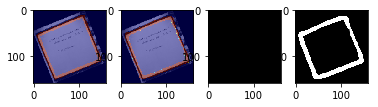

In [5]:
draw_example(valid_imgs, include_alpha=False)

(64, 160, 160, 5) (64, 160, 160, 1)
(64, 160, 160, 1)
(64, 160, 160, 1)


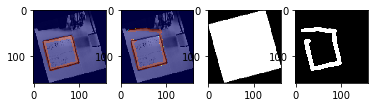

In [11]:
draw_example(test_imgs)

(1, 160, 160, 5) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


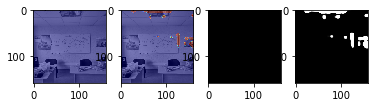

In [14]:
from skimage import img_as_float

import os
img_dir = '/home/bfilippov/our_room/'

def arr(img):
    img = img_as_float(cv2.imread(img))
    img = cv2.resize(img, (160, 160))
    cv2.normalize(img, img, 0, 1, norm_type=cv2.NORM_MINMAX,
              dtype=cv2.CV_32F)
    img = np.dstack([img, np.zeros((160, 160))])
    img = np.array([img])
    return img

imgs = [(arr(os.path.join(img_dir, fname)), np.zeros((1, 10))) for fname in os.listdir(img_dir)]

draw_example(patch(imgs.__iter__()), img_ix=0)


(1, 160, 160, 5) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


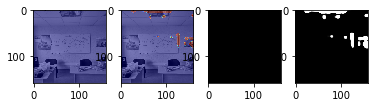

In [15]:
draw_example(patch(imgs[0:].__iter__()), img_ix=0)

(1, 160, 160, 5) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


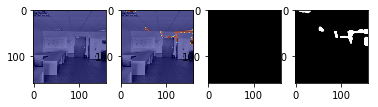

In [17]:
draw_example(patch(imgs[1:].__iter__()), img_ix=0)

(1, 160, 160, 5) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


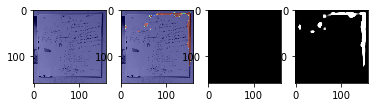

In [18]:
draw_example(patch(imgs[2:].__iter__()), img_ix=0)

(1, 160, 160, 5) (1, 160, 160, 1)
(1, 160, 160, 1)
(1, 160, 160, 1)


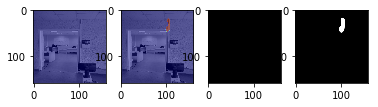

In [19]:
draw_example(patch(imgs[3:].__iter__()), img_ix=0)